In [2]:
import numpy as np # Linear algebra
# Data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
from pandas import DataFrame
import xml.etree.ElementTree as ET # Reading xml files
# For plotting
import matplotlib.pyplot as plt
import pydot
import pydotplus
import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from sklearn.manifold import TSNE
# For Modelling
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, callbacks, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.metrics import categorical_accuracy
# For Pre-processing
import string
from string import digits
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
# Other useful modules
import h5py
from statistics import mode
import os
import datetime
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')

In [3]:
def csv_row(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    nct_text = ""
    sum_text = ""
    model_text = ""
    ph_text = ""
    title_text = ""
    # Only iterates through Phase 2 and 3 studies
    for ph in root.iter('phase'):
        ph_text = ph.text
        if (ph_text == "Phase 2" or ph_text == "Phase 3" or ph_text == "Phase 1"):
            #This bit finds all roots with nct_id which is a sub_root to id_info
            for nct in root.findall('id_info'):
                nctId_text = nct.find('nct_id').text
                nct_text =nctId_text
            # This bit finds the brief summary text
            for s in root.findall('brief_summary'):
                summary_text = s.find('textblock').text
                sum_text= summary_text
                sum_text = sum_text.replace('\r\n', '') # Replaces newline with a whitespace
                sum_text = re.sub(' +',' ',sum_text) # Compresses multiple whitespaces to only one
                #print("Summary Text:", sum_text)
            # Get's the official title for the study
            for t in root.iter('brief_title'):
                title_text = t.text
            # This get's the type of intervention_model
            for y in root.iter('intervention_model'):
                model_text = y.text
            for s in root.iter('start_date'):
                start_date = s.text
            for c in root.iter('completion_date'):
                
                completion_date = c.text
    total_text = "\"" + nct_text + "\"" + ";" + "\"" + sum_text + "\"" + ";"  + "\"" + title_text + "\"" + ";"  +  "\"" + model_text + "\""+ ";"  + "\"" + start_date + "\""+ ";"  + "\"" + completion_date + "\""
    # This functions returns a text with Nct_Id, brief_summary, title and type of intervention model on the form we intended
    return total_text
print(csv_row("Downloads\\search_result (1)\\NCT00041080.xml"))

"NCT00041080";"
 Randomized phase III trial to compare the effectiveness of tamoxifen with that of thalidomide in treating women who have recurrent ovarian epithelial cancer, fallopian tube cancer, or primary peritoneal cancer. Estrogen can stimulate the growth of some types of cancer cells. Hormone therapy using tamoxifen may fight cancer by blocking the uptake of estrogen. Thalidomide may stop the growth of cancer by stopping blood flow to the tumor. It is not yet known whether thalidomide is more effective than tamoxifen in treating ovarian epithelial cancer, fallopian tube cancer, or primary peritoneal cancer. ";"Tamoxifen Compared With Thalidomide in Treating Women With Ovarian Epithelial Cancer, Fallopian Tube Cancer, or Primary Peritoneal Cancer";"Parallel Assignment";"February 2003";"January 2011"


In [5]:
rdir = "Downloads\\search_result (1)"# Folders in directory where the all the xml files are placed
with open('train_data.csv', 'w', encoding="utf-8") as csvfile: 
    for root, dirs, files in os.walk(rdir):
        for filename in files:
            name = os.path.join(root, filename)
            csvfile.write(csv_row(name)) #Writes total_text into a row in to train_data.csv
            csvfile.write("\n") # Skips to next line and do the same

UnboundLocalError: local variable 'completion_date' referenced before assignment

In [4]:
# Earlier we saw that the returned text from our function was seperated by ';', so we use this as seperator when reading in the files
df = pd.read_csv("train_data.csv", sep=';', header=None,error_bad_lines=False, warn_bad_lines=False)
# Give the data sets appropiate column names
df.columns =  ['Nct_id', 'Summary', 'Title','Model','Start Date','End Date']
# We drop all the observations containing NaN's (missing values)
train = df.dropna()
for i,row in train.iterrows():
    if("\r\n" in row['Summary']):
        row['Summary'] = row['Summary'].replace("\r\n", '')
print(train)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 6 elements

In [5]:
X = train.drop(['Model'], axis=1)
Y = train.drop(['Nct_id','Summary','Title'], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [6]:
# We want 4 categories: Crossover, Parallel, Single Group and Other
Y_train.loc[(Y_train['Model'] == 'Factorial Assignment'), 'Model'] = 'Other'
Y_train.loc[(Y_train['Model'] == 'Sequential Assignment'), 'Model'] = 'Other'
Y_test.loc[(Y_test['Model'] == 'Factorial Assignment'), 'Model'] = 'Other'
Y_test.loc[(Y_test['Model'] == 'Sequential Assignment'), 'Model'] = 'Other'
# Convert from object to category
Y_train['Model'] = Y_train['Model'].astype('category')
Y_test['Model'] = Y_test['Model'].astype('category')
#Label encoding
Y_train["Model_type"] = Y_train["Model"].cat.codes
Y_test["Model_type"] = Y_test["Model"].cat.codes
print(Y_train.head()) # Prints the first 5 rows of the data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

                        Model  Model_type
8057      Parallel Assignment           2
7177  Single Group Assignment           3
6651  Single Group Assignment           3
4648  Single Group Assignment           3
4892  Single Group Assignment           3
(6243, 3)
(6243, 2)
(1561, 3)
(1561, 2)


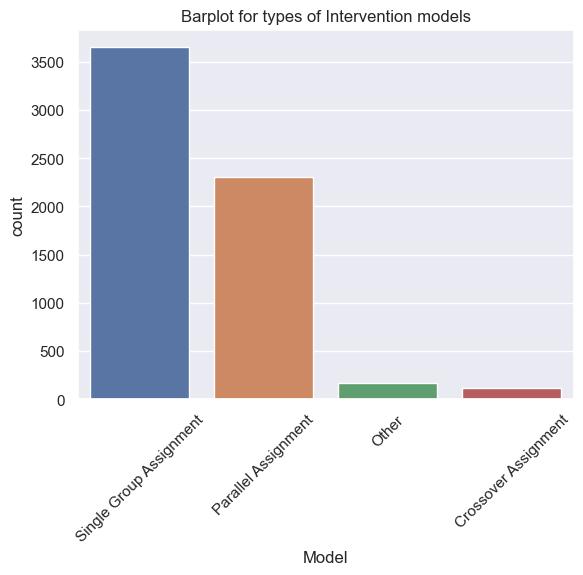

In [7]:
import seaborn as sns
sns.set(style="darkgrid")
ax1 = sns.countplot(x="Model", data=Y_train, order = Y_train['Model'].value_counts().index)
ax1.set_title("Barplot for types of Intervention models")
for item in ax1.get_xticklabels():
    item.set_rotation(45)

In [8]:
# One Hot Encoding
train_dummy = pd.get_dummies(Y_train, columns=['Model'], prefix =['Model'])
test_dummy = pd.get_dummies(Y_test, columns=['Model'], prefix =['Model'])
print(train_dummy)
print("Train shape:",train_dummy.shape)
print("Test shape:",test_dummy.shape)

      Model_type  Model_Crossover Assignment  Model_Other  \
8057           2                           0            0   
7177           3                           0            0   
6651           3                           0            0   
4648           3                           0            0   
4892           3                           0            0   
...          ...                         ...          ...   
8273           1                           0            1   
3756           3                           0            0   
8749           3                           0            0   
1826           0                           1            0   
3686           3                           0            0   

      Model_Parallel Assignment  Model_Single Group Assignment  
8057                          1                              0  
7177                          0                              1  
6651                          0                              1  
4648   

In [9]:
import nltk
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
# This needs to be download for the lemmatization (converting to base form)
def text_cleaner(dataframe_org):
    dataframe = dataframe_org.copy()
    columns = ['Summary', 'Title']
    for col in columns:
        dataframe[col] = dataframe[col].str.translate(str.maketrans(' ', ' ', string.punctuation)) # Remove punctuation
        dataframe[col] = dataframe[col].str.translate(str.maketrans(' ', ' ', '\n')) # Remove newlines
        dataframe[col] =dataframe[col].str.translate(str.maketrans(' ', ' ', digits)) # Remove digits
        dataframe[col] =dataframe[col].apply(lambda tweet: re.sub(r'([a-z])([A-Z])',r'\1 \2',tweet)) # Split combined words
        dataframe[col] =dataframe[col].str.lower() # Convert to lowercase
        dataframe[col] =dataframe[col].str.split() # Split each sentence using delimiter
    # This part is for converting to base form
    lemmatizer = WordNetLemmatizer()
    sum_l=[]
    tit_l = []
    for y in tqdm(dataframe[columns[0]]): # tqdm is just a progress bar, an this loop only looks at summaries
        sum_new=[]
        for x in y: # Looks at words in every summary text
            z=lemmatizer.lemmatize(x)
            z=lemmatizer.lemmatize(z,'v') # The v specifies that it is in doubt of example a word is a noun or verb, it would consider it a verb.
            sum_new.append(z)
        y = sum_new
        sum_l.append(y)
    for w in tqdm(dataframe[columns[1]]): # Looks at titles
        tit_new=[]
        for x in w: # Every word in the titles
            z=lemmatizer.lemmatize(x)
            z=lemmatizer.lemmatize(z,'v')
            tit_new.append(z)
        w = tit_new
        tit_l.append(w)
    # This will join the words into strings as in the original data, just pre-processed and put into list
    sum_l2 = []
    for col in sum_l:
        col = ' '.join(col)
        sum_l2.append(col)
    tit_l2 = []
    for col in tit_l:
        col = ' '.join(col)
        tit_l2.append(col)
    # Data obtained after Lemmatization is in array form, and is converted to Dataframe in the next step.
    sum_data=pd.DataFrame(np.array(sum_l2), index=dataframe.index,columns={columns[0]})
    tit_data=pd.DataFrame(np.array(tit_l2), index=dataframe.index,columns={columns[1]})
    frames = [sum_data, tit_data]
    merged = pd.concat(frames, axis=1)
    return merged
def create_tok(train_data, MAX_FEATURES):
    clean_data = text_cleaner(train_data)
    tokenizer_sum = text.Tokenizer(num_words=MAX_FEATURES) # Keep the 20.000 most frequent words
    tokenizer_tit =  text.Tokenizer(num_words=MAX_FEATURES)
    # Summary Text
    summary_list = clean_data['Summary']
    tokenizer_sum.fit_on_texts(list(summary_list)) # Builds the word index
    #Title Text
    title_list = clean_data['Title'] # Text from Title
    tokenizer_tit.fit_on_texts(list(title_list))
    return tokenizer_sum, tokenizer_tit
def pre_process(dataframe, tokenizer, col, MAXLEN):
    clean_data = text_cleaner(dataframe)
    tokenized_list = tokenizer.texts_to_sequences(clean_data[col])
    X = sequence.pad_sequences(tokenized_list, maxlen=MAXLEN)
    return X

In [30]:
MAX_FEATURES = 20000 # Size of vocabluary
MAXLEN = 220 # Size of each text sequence, you can tune this depending on the mean length of you text sequences
tok_sum, tok_tit = create_tok(X_train,MAX_FEATURES )
# The following are used for model.fit
X_sum = pre_process(X_train, tok_sum, 'Summary', MAXLEN)
X_tit = pre_process(X_train, tok_tit, 'Title', MAXLEN)
print(X_sum)
print(X_tit)
# This is used for prediction
X_sum_test = pre_process(X_test, tok_sum, 'Summary', MAXLEN)
X_tit_test = pre_process(X_test, tok_tit, 'Title', MAXLEN)
list_classes = ["Model_Crossover Assignment", "Model_Other", "Model_Parallel Assignment", "Model_Single Group Assignment"] # The 4 categories
y = train_dummy[list_classes].values
# y_test is used for model.evaluate later on
y_test = test_dummy[list_classes].values

100%|███████████████████████████████████████████████████████████████████████████| 6243/6243 [00:00<00:00, 17279.30it/s]


[[   0    0    0 ...   70    3 1357]
 [   0    0    0 ...   10    3  147]
 [   0    0    0 ...    5    1   26]
 ...
 [  30    3  527 ...   10   33  399]
 [   0    0    0 ...    7  562    9]
 [   0    0    0 ...    4 3113  378]]
[[   0    0    0 ...    2  133 1168]
 [   0    0    0 ...  461    1  478]
 [   0    0    0 ...   99 1004    3]
 ...
 [   0    0    0 ...    1   50    3]
 [   0    0    0 ...    2  221    3]
 [   0    0    0 ...   11   42    3]]


100%|███████████████████████████████████████████████████████████████████████████| 1561/1561 [00:00<00:00, 16728.90it/s]


In [31]:
def get_con_model():
    embed_size = 50 # How big  each word vector should be
    inp_sum = Input(shape=(MAXLEN, ))
    inp_title = Input(shape=(MAXLEN, ))
    total_inp = concatenate([inp_sum, inp_title]) # Merge the 2 inputs
    embed_layer = Embedding(MAX_FEATURES, embed_size)(total_inp)
    lstm_layer = LSTM(50)(embed_layer)
    layer1 = Dropout(0.1)(lstm_layer) # Regularization method, has the effect of reducing overfitting
    layer2 = Dense(50, activation="relu")(layer1) # The relu function can return very large values
    layer3 =  Dropout(0.1)(layer2) # Again regularization
    layer4 =BatchNormalization()(layer3) # Maintains the mean activation close to 0 and the activation standard deviation close to 1
    layer5 = Dense(4, activation="softmax")(layer4) # Only outputs values between 0 and 1, this is the final layer
    model_con = Model(inputs=[inp_sum,inp_title], outputs=layer5)
    model_con.compile(loss='categorical_crossentropy', # This is the loss function, and this type of function is used when solving categorical classification
                    optimizer='rmsprop', # Algorithm that update network weights iterative based in training data
                    metrics=['accuracy']) # This is our statistical measure
    return model_con
con_model = get_con_model()
# Gets informations about the layers in the model, including output, input and number of parameters:
con_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 220)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 220)]        0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 440)          0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 440, 50)      1000000     ['concatenate_2[0][0]']    

In [ ]:
batch_size = 32 # number of samples that will be propagated through the network.
epochs = 10 # Number of passes over the entire data set
file_path="weights_base.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min') # Verbose means that it prints acc and loss
early = EarlyStopping(monitor="val_loss", mode="min", patience=3) 
#EarlyStopping should only be includede when tuning your model
callbacks_list = [checkpoint, early]
history = con_model.fit([X_sum, X_tit], y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list, verbose=2) # Model fit

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.80971, saving model to weights_base.hdf5
176/176 - 13s - loss: 0.9524 - accuracy: 0.6346 - val_loss: 0.8097 - val_accuracy: 0.6112 - 13s/epoch - 77ms/step
Epoch 2/10


In [ ]:
con_model.load_weights(file_path)
con_model.evaluate([X_sum_test, X_tit_test], y_test, verbose=2) # Returns loss value and the metric specified, so in this case, model accuracy